In [57]:
import keras as keras
from keras.datasets import mnist
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, classification_report

#import tensorflow_addons as tfa

Cargamos los datos tanto de entrada (train y test) y sus respectivos labels.

In [58]:

(x_train_ps, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [59]:
#Funcion para utilizar en el EDA
def EDA_plothist(data,histname):
  unique, counts = np.unique(data, return_counts=True)
  counts = np.bincount(data)
  fig, ax = plt.subplots(figsize=(10,5))
  ax.bar(range(10), counts, width=0.8, align='center')
  ax.set(xticks=range(10), xlim=[-1, 10], title=histname)
  plt.show()

In [60]:


#plt.imshow(x_train[1,...], cmap='gray')
#print(y_train.shape,x_train.shape)

# Exploratory Data Analisys
Observaremos sobre los datos a procesar, para caracterizar el problema a resolver.


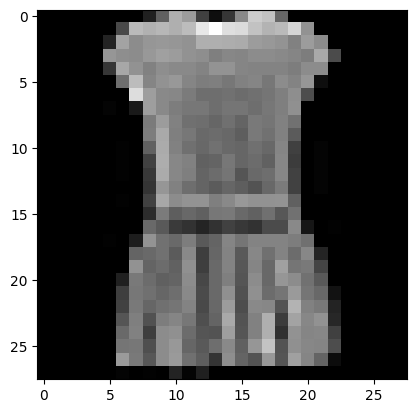

In [61]:
plt.imshow(x_train_ps[3,...], cmap="gray")

El dataset cuenta con 70.000 imagenes de 28x28px que corresponden a imagenes en un solo canal de 10 categorias de prendas de ropa diferentes. A continuacion mostramos un ejemplo de cada clase:

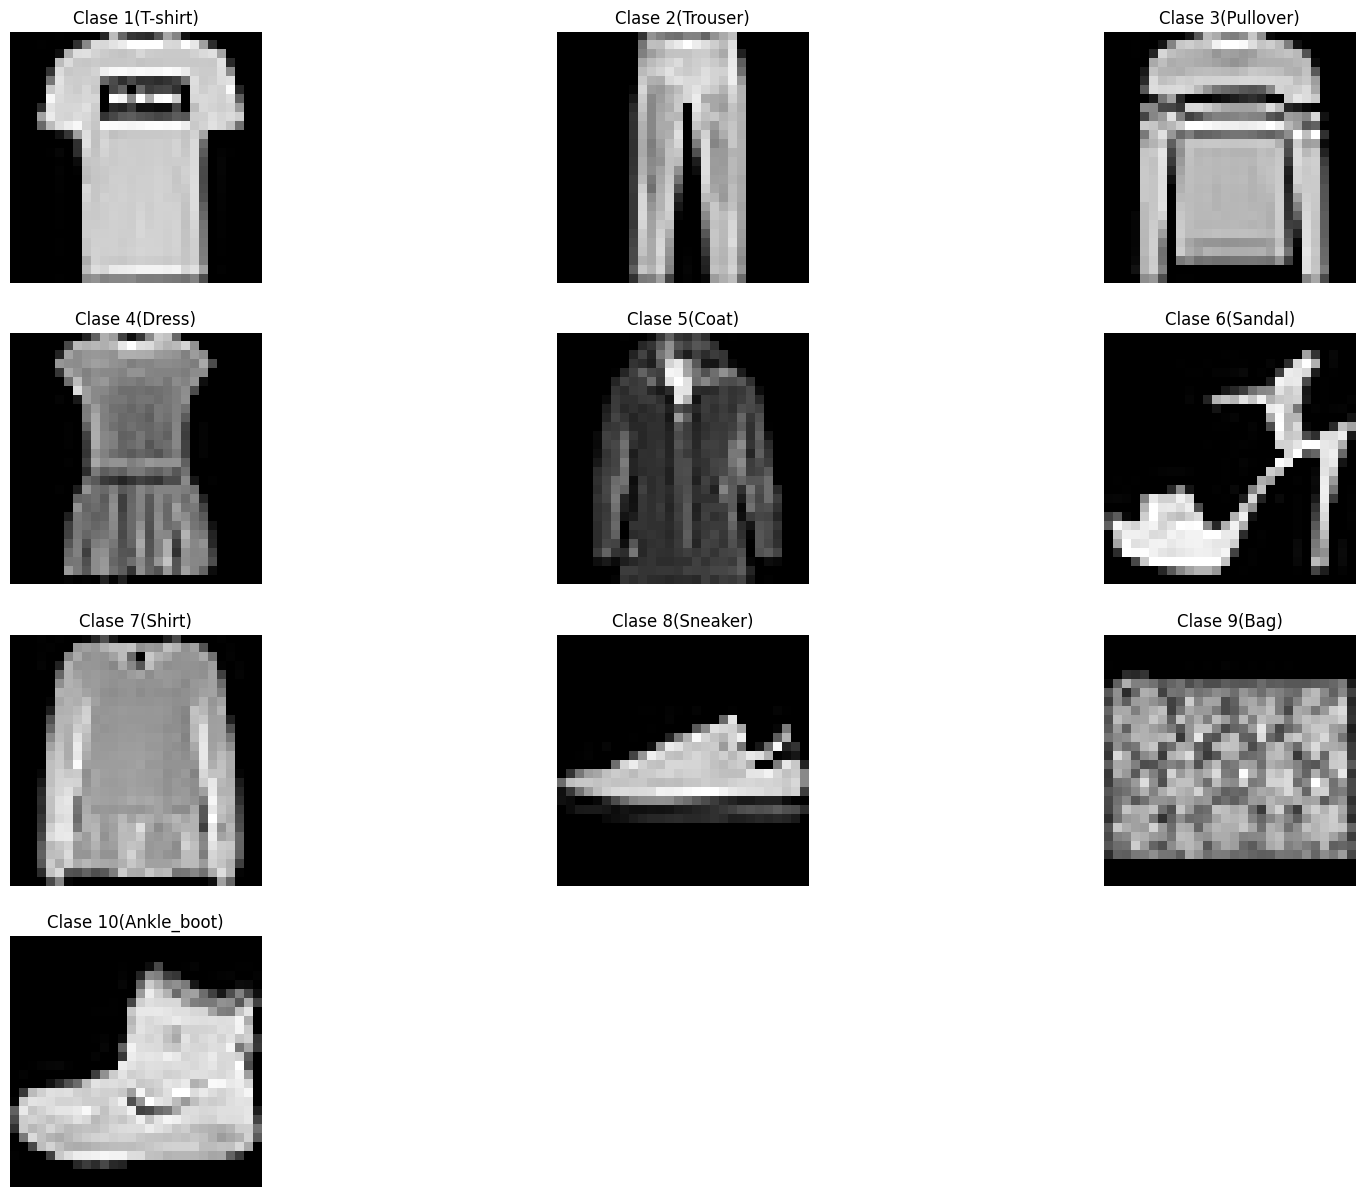

In [62]:
#Indices a ejemplos

ejs=[1, 16, 5, 3, 19, 9, 18, 6, 23, 0]
prendas=[]
classes_fashion={
1: "T-shirt",
2: "Trouser",
3: "Pullover",
4: "Dress",
5: "Coat",
6: "Sandal",
7: "Shirt",
8: "Sneaker",
9: "Bag",
10: "Ankle_boot"}
# create figure
fig = plt.figure(figsize=(20, 15))
# setting values to rows and column variables
rows = 4
columns = 3
fig_counter=1
# Adds a subplot at the 1st position
for ej in ejs:
  fig.add_subplot(rows, columns, fig_counter)
  plt.imshow(x_train_ps[ej],cmap="gray")
  plt.axis('off')
  plt.title("Clase "+str(fig_counter)+'('+classes_fashion[fig_counter]+')')
  fig_counter=fig_counter+1



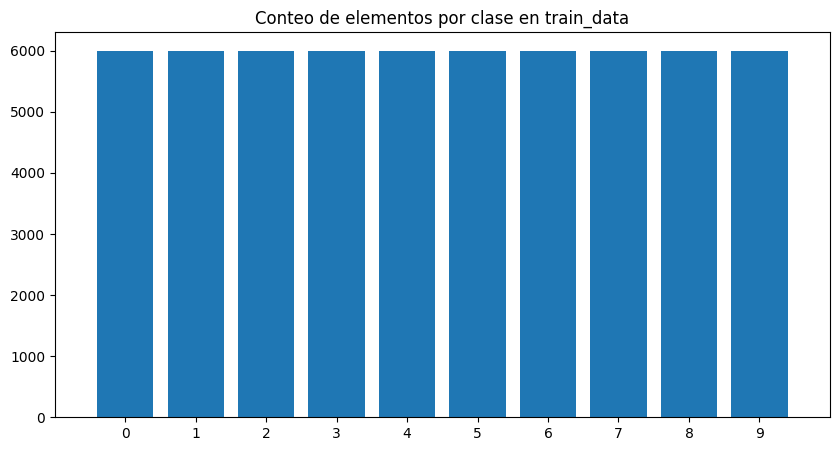

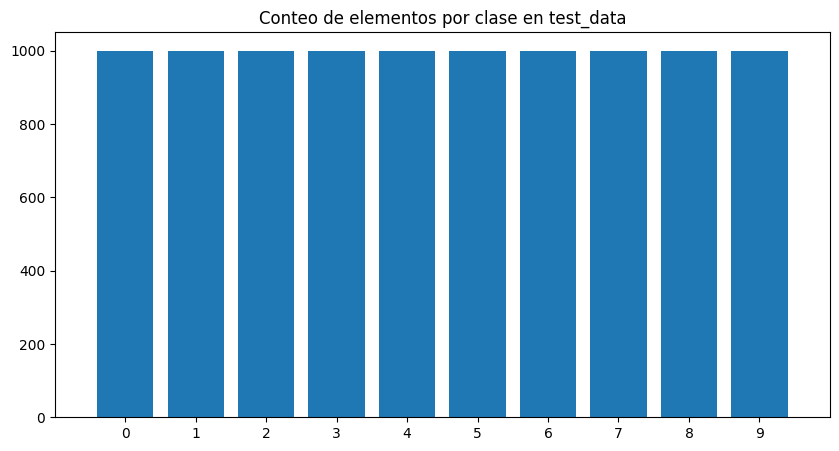

In [63]:
# counts, bins = np.histogram(y_train)
# print(counts,"+  ",bins)
# plt.xticks(range(11));
# plt.hist(bins, bins=10, weights=counts, histtype='bar', align='mid')
EDA_plothist(y_train,"Conteo de elementos por clase en train_data")
EDA_plothist(y_test,"Conteo de elementos por clase en test_data")


#Procesamiento de datos:
1)One hot encoding de las clases:

In [64]:

y_sparse_train = np.zeros([60000,10])
y_sparse_test = np.zeros([10000,10])
for idx in range(60000):
    y_sparse_train[idx,y_train[idx]] = 1

for idx in range(10000):
    y_sparse_test[idx,y_test[idx]] = 1



2)Separo en train y validate, luego normalizo los datos:

In [65]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train_ps, y_sparse_train, test_size=0.4)

# Normalizacion "a mano"
x_train = x_train/255
x_test= x_test/255
x_validate = x_validate/255

#x_test = x_test
print(np.max(x_train))
print(x_validate.shape)
print(x_train.shape)
print(y_validate.shape)
#


1.0
(24000, 28, 28)
(36000, 28, 28)
(24000, 10)


Hasta aqui preprocesamiento
Ahora definiré el modelo propiamente.

In [66]:
from keras.models import Sequential
import keras.layers
from keras.layers import Dense, Flatten
from keras.optimizers import SGD, Adam, adagrad




#Defino mis funciones de exploración
Pretendo loopear a traves de las mismas, creando a partir de ellas diversos modelos afín de compararlos.

In [67]:
#Funcion que crea un modelo basado en un clasificador softmax de una capa de aplanamiento y una de clasificacion con activacion softmax
#Guardado de metricas y early stopping activados, modificable para realizar pruebas
# Parametros: Optimizador (string preseteado o callback), metodo de regularizacion de pesos y de inicializacion de pesos. Además se especidifca si se requiere o no de batch normalization
def new_model_softmax (optimizador='Adam',kernreg='l1',kerninit='normal',batch_normalization=False, batchsize = 32):
  nClases = 10
  if kernreg== 'none':
    model_name = "Modelo con optimizacion "+optimizador+", Sin regularizacion de pesos y inicializados segun "+kerninit+ ",con BtchSize = "+str(batchsize)
  else:
    model_name = "Modelo con optimizacion "+optimizador+", Regularizacion kernel "+kernreg+" y inicializados segun "+kerninit+ ", con BtchSize = "+str(batchsize)

  print(model_name)
  #Early Stopping
  es = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    min_delta=0.001,
    patience=10,
    verbose=1,
    mode="max",
    baseline=60,
    restore_best_weights=True,
    start_from_epoch=0)
  #Callbacks para guardar datos
  mc = tf.keras.callbacks.ModelCheckpoint(model_name+'.h5', monitor='val_accuracy',mode='max',verbose=1,save_best_only=True)
  model = Sequential()
  model.add(Flatten(input_shape=(28,28,1)))
  if bool(batch_normalization):
    model.add(keras.layers.BatchNormalization())
  if kernreg== 'none':
    model.add(Dense(nClases, activation="softmax",kernel_initializer=kerninit))
  else:
    model.add(Dense(nClases, activation="softmax",kernel_initializer=kerninit,kernel_regularizer=kernreg))
  model.compile(loss= 'categorical_crossentropy', optimizer=optimizador,
                  metrics=["accuracy"])
  model.summary()
  history = model.fit(x= x_train, y = y_train, validation_data=(x_validate, y_validate), batch_size = batchsize, epochs=200, callbacks=[es,mc])
  val_los, val_acc = model.evaluate(x_test,y_sparse_test)
  y_pred = model.predict(x_test)
  y_pred = np.argmax(y_pred, axis = 1)
  print(y_pred,y_test)
  classification_rep = classification_report(y_test,y_pred,output_dict=True)
  #Calculo cantidad de iteraciones del tomadas para entrenar el modelo
  iterations = len(history.history['accuracy']) * batchsize # Iterations = num of epochs * batch size
  return (history,classification_rep,model_name,iterations)



#Funcion que plotea los graficos de accuracies y losses. Agrupa de a N modelos
def plot_compare(results_vector, models_perfig=5):
  iterations = list()
  model_count = len(results_vector)
  #Iteramos entre todos los modelos a.k.a resultados y agrupamos de a 5 por grafico.
  for i in range(model_count):
    plt.plot(results_vector[i][0].history['loss'], label="M "+str(i)+" train")#Plot de los
    plt.plot(results_vector[i][0].history['val_loss'],'--', label="M "+str(i)+" test")
    if (i+1)%models_perfig==0:
      plt.title('Losses vs Epoch')
      plt.legend(loc='upper right')
      plt.show()
    elif i+1==model_count:
      plt.title('Losses vs Epoch')
      plt.legend(loc='upper right')
      plt.show()


  for i in range(len(results_vector)):
    plt.plot(results_vector[i][0].history['accuracy'], label="M "+str(i)+" train")#Plot de los
    plt.plot(results_vector[i][0].history['val_accuracy'],'--' , label="M "+str(i)+" test")
    iterations.append(results_vector[i][3])
    if (i+1)%4==0:
      plt.title('Accuracy vs Epoch')
      plt.legend(loc='lower right')
      plt.show()
    elif i+1==model_count:
      plt.title('Accuracy vs Epoch')
      plt.legend(loc='lower right')
      plt.show()
  #Grafico de barras para iteraciones por modelo
  barWidth = 0.33
  fig = plt.subplots(figsize =(12, 8))
  br1 = np.arange(len(iterations))
  plt.bar(br1, iterations, color ='g', width = barWidth,
        edgecolor ='grey', label ='Number of Steps')
  plt.xlabel('Número de Modelo', fontweight ='bold', fontsize = 10)
  plt.ylabel('Iteraciones', fontweight ='bold', fontsize = 10)
  plt.xticks([r for r in range(len(results_vector))])
  plt.grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)

  plt.title('Steps vs #Model',
             loc ='left', )
  plt.legend()
  plt.show()


def plot_class_reports(results_vector):
  clases_dict=['0','1','2','3','4','5','6','7','8','9']
  metricas_dict=['precision','recall','f1-score','support']
  colores = ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']
  precision_vect= []
  recall_vect=[]
  f1_vect=[]
  nClases = 10
  axis_ID=0
  deca_count = 0
  x = np.arange(10)
  subplot_count = 3*((int(len(results_vector)/10))+1)
  fig, ax = plt.subplots(subplot_count,figsize=(25,15))
  print(len(results_vector))
  for j in range(len(results_vector)):
    if j>0 and (j%10)==0 :
      axis_ID = axis_ID + 3
      deca_count = deca_count + 10

    for i in range(nClases):
      precision_vect.append(results_vector[j][1][clases_dict[i]][metricas_dict[0]])
      recall_vect.append(results_vector[j][1][clases_dict[i]][metricas_dict[1]])
      f1_vect.append(results_vector[j][1][clases_dict[i]][metricas_dict[2]])
    ax[axis_ID].stem(x+(j-deca_count)*0.09, precision_vect[(j*10):(((j+1)*10))], label="M"+str(j),linefmt=colores[j-deca_count])
    ax[axis_ID].set(xlim=(0, 10), xticks=np.arange(0, 10),
      ylim=(0, 1.1), yticks=np.arange(0,1,0.1))
    ax[axis_ID+1].stem(x+(j-deca_count)*0.09, recall_vect[(j*10):(((j+1)*10))], label="M"+str(j),linefmt=colores[j-deca_count])
    ax[axis_ID+1].set(xlim=(0, 10), xticks=np.arange(0, 10),
      ylim=(0, 1.1), yticks=np.arange(0,1,0.1))
    ax[axis_ID+2].stem(x+(j-deca_count)*0.09, f1_vect[(j*10):(((j+1)*10))], label="M"+str(j),linefmt=colores[j-deca_count])
    ax[axis_ID+2].set(xlim=(0, 10), xticks=np.arange(0, 10),
      ylim=(0, 1.1), yticks=np.arange(0,1,0.1))

  for axcount in range(subplot_count):
    models_ids = int(axcount/3)*10
    title_start = metricas_dict[axcount%3]
    if axcount%3==0:
      ax[axcount].legend(loc='best')
    title=title_start+" modelos "+str(models_ids)+" al "+str(models_ids+len(results_vector))
    ax[axcount].set_title( label = title , fontdict=None, loc='center', pad=0.8)
  plt.show()

#Funcion que extrae los mejores modelos en cada una de las métricas.
def print_best_models(results_vector):
  result_count = len(results_vector)

  acc_vect=[]
  valacc_vect=[]
  loss_vect=[]
  valloss_vect=[]
  for result in range(result_count):
    acc_vect.append(max(results_vector[:][result][0].history['accuracy']))
    valacc_vect.append(max(results_vector[:][result][0].history['val_accuracy']))
    loss_vect.append(max(results_vector[:][result][0].history['loss']))
    valloss_vect.append(max(results_vector[:][result][0].history['val_loss']))

  max_accuracy_index = acc_vect.index(max(acc_vect))
  max_valaccuracy_index = valacc_vect.index(max(valacc_vect))
  min_loss_index = loss_vect.index(min(loss_vect))
  min_valloss_index = valloss_vect.index(min(valloss_vect))
  print("El modelo con mejor accuracy de train es el: M",max_accuracy_index," (",results_vector[max_accuracy_index][2],") ----> Acc:",acc_vect[max_accuracy_index])
  print("El modelo con mejor accuracy de validacion es el: M",max_valaccuracy_index," (",results_vector[max_valaccuracy_index][2],") ----> ValAcc:",valacc_vect[max_valaccuracy_index])
  print("El modelo con mejor loss de train es el: M",min_loss_index,"(",results_vector[min_loss_index][2],") ----> Loss:",loss_vect[min_loss_index])
  print("El modelo con mejor loss de validacion es el: M",min_valloss_index,"(",results_vector[min_valloss_index][2],") ----> ValLoss:",valloss_vect[min_valloss_index])


#Batch size
Definimos un modelo basico y variamos el batch size.


Modelo con optimizacion Adam, Regularizacion kernel l1 y inicializados segun normal, con BtchSize = 8
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_9 (Flatten)         (None, 784)               0         
                                                                 
 dense_9 (Dense)             (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
4489/4500 [============================>.] - ETA: 0s - loss: 1.7861 - accuracy: 0.7026
Epoch 1: val_accuracy improved from -inf to 0.71529, saving model to Modelo con optimizacion Adam, Regularizacion kernel l1 y inicializados segun normal, con BtchSize = 8.h5
4500/4500 [==============================] - 17s 4ms/step - loss: 1.7859 

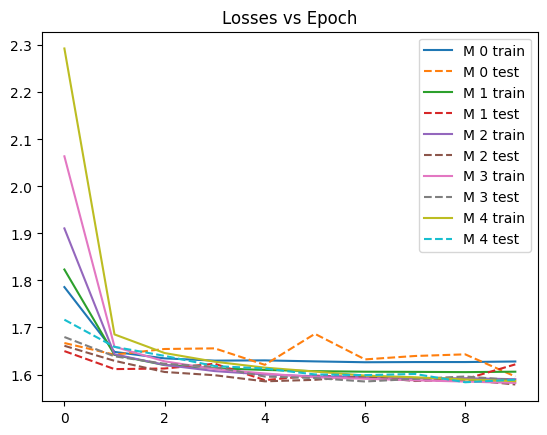

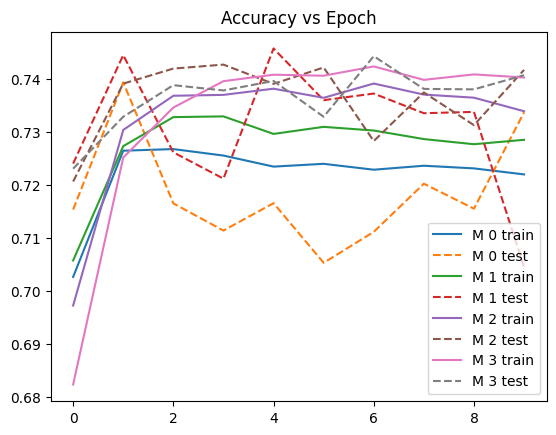

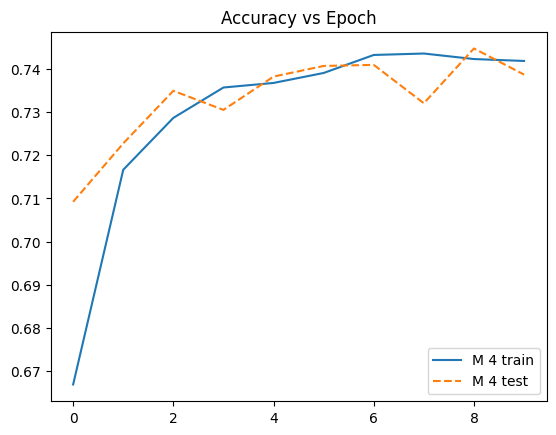

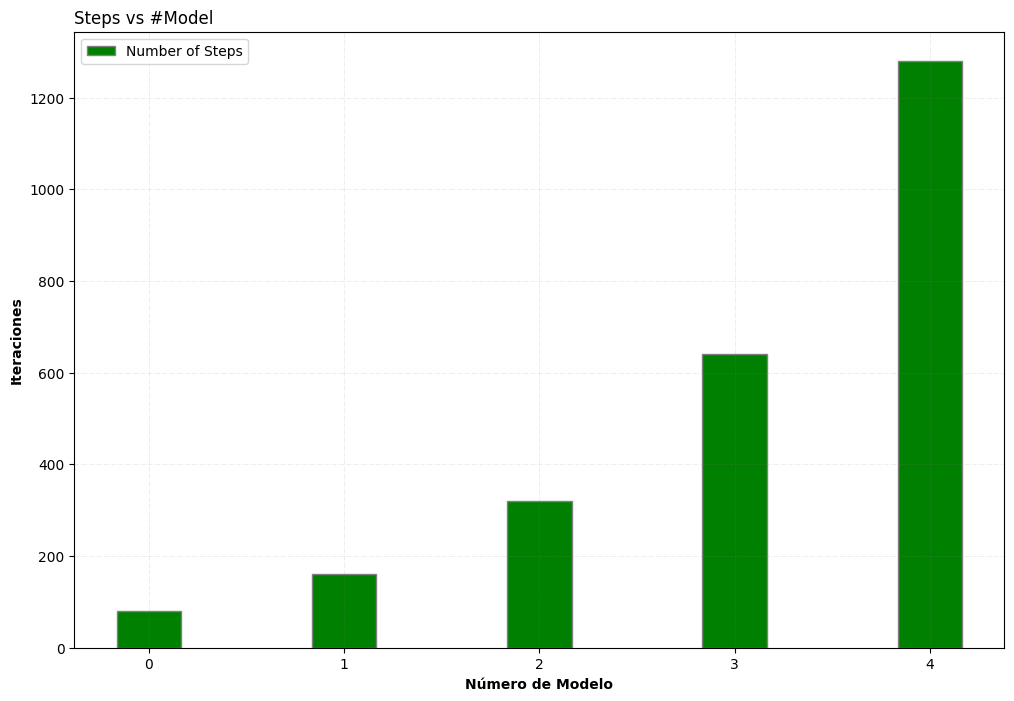

5


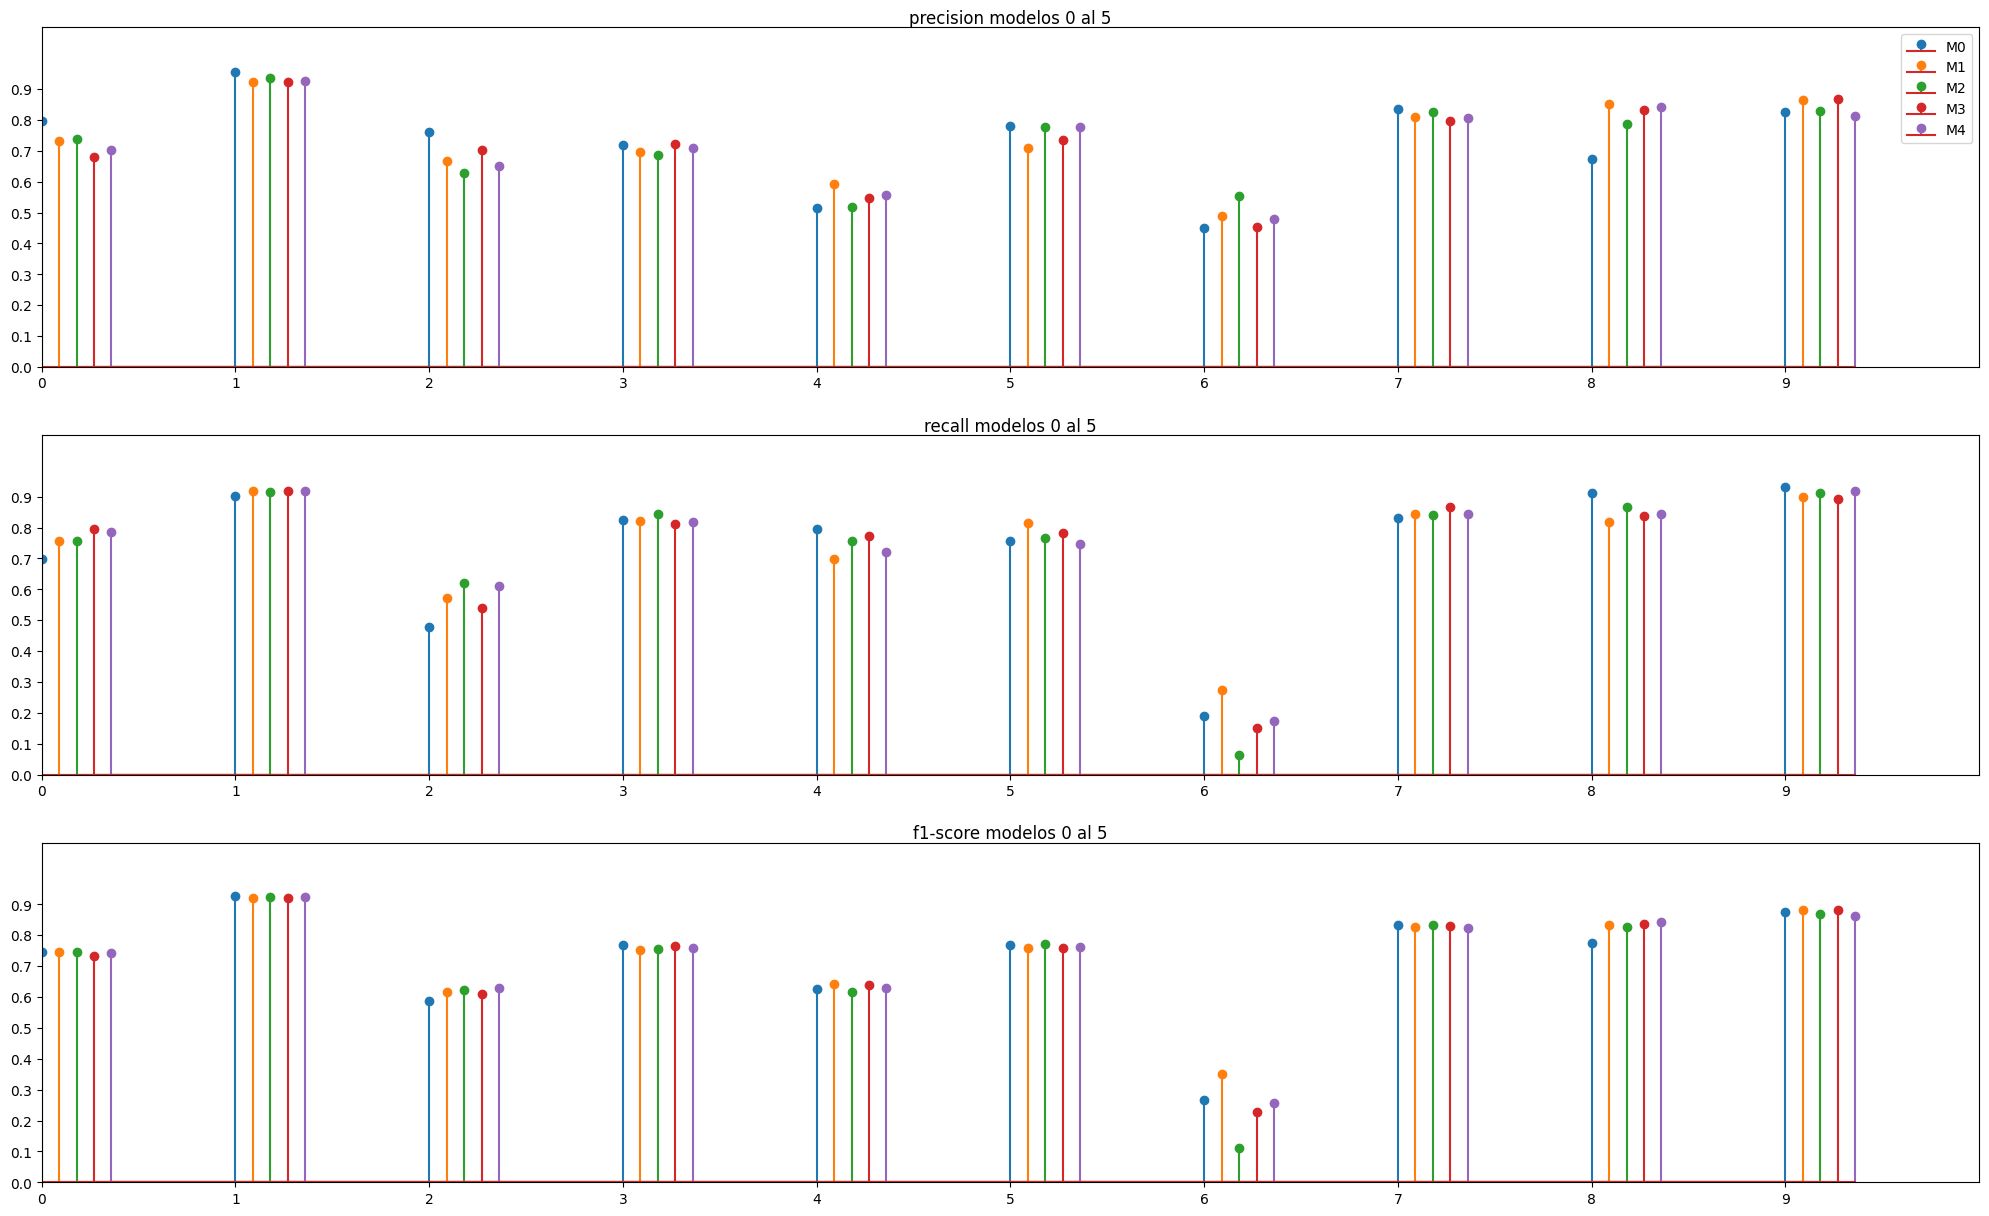

El modelo con mejor accuracy de train es el: M 4  ( Modelo con optimizacion Adam, Regularizacion kernel l1 y inicializados segun normal, con BtchSize = 128 ) ----> Acc: 0.7434999942779541
El modelo con mejor accuracy de validacion es el: M 1  ( Modelo con optimizacion Adam, Regularizacion kernel l1 y inicializados segun normal, con BtchSize = 16 ) ----> ValAcc: 0.7456666827201843
El modelo con mejor loss de train es el: M 0 ( Modelo con optimizacion Adam, Regularizacion kernel l1 y inicializados segun normal, con BtchSize = 8 ) ----> Loss: 1.785888910293579
El modelo con mejor loss de validacion es el: M 1 ( Modelo con optimizacion Adam, Regularizacion kernel l1 y inicializados segun normal, con BtchSize = 16 ) ----> ValLoss: 1.6497830152511597


In [68]:
 batchsize_list=[8,16,32,64,128]
 results_bs_vector = list()
 for batchsizes in batchsize_list:
        model_results_tuple = new_model_softmax(batchsize=batchsizes)
        results_bs_vector.append(model_results_tuple)
plot_compare(results_bs_vector)
plot_class_reports(results_bs_vector)
print_best_models(results_bs_vector)

Notamos que aumentar el batchsize no necesariamente implica metricas ampliamente superiores. La gran diferencia ocurre cuando observamos la cantidad de iteraciones que conllevó el entrenamiento de cada uno de los modelos, donde observamos que al aumentar el batch size se incrementa proporcionalmente el recuento de las mismas. Por eso, apuntaremos a un batch size mas bien pequeño, pero no demasiado. Para las siguientes pruebas se tomo fijo en 32.

##Optimizadores


Modelo con optimizacion SGD, Regularizacion kernel l1 y inicializados segun normal, con BtchSize = 32
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_14 (Flatten)        (None, 784)               0         
                                                                 
 dense_14 (Dense)            (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
1103/1125 [============================>.] - ETA: 0s - loss: 2.4955 - accuracy: 0.6628
Epoch 1: val_accuracy improved from -inf to 0.70346, saving model to Modelo con optimizacion SGD, Regularizacion kernel l1 y inicializados segun normal, con BtchSize = 32.h5
1125/1125 [==============================] - 4s 3ms/step - loss: 2.4816 

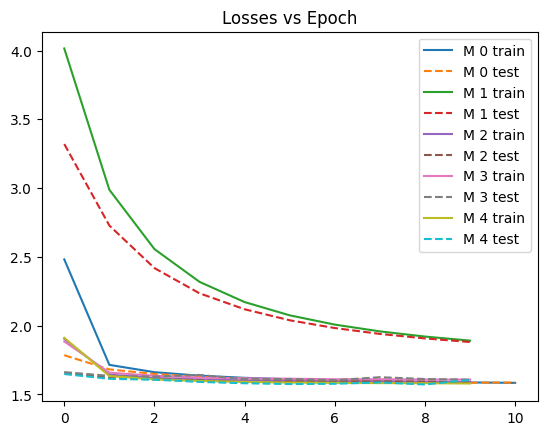

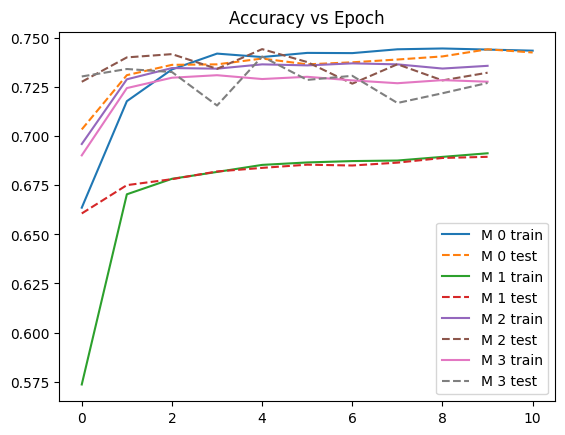

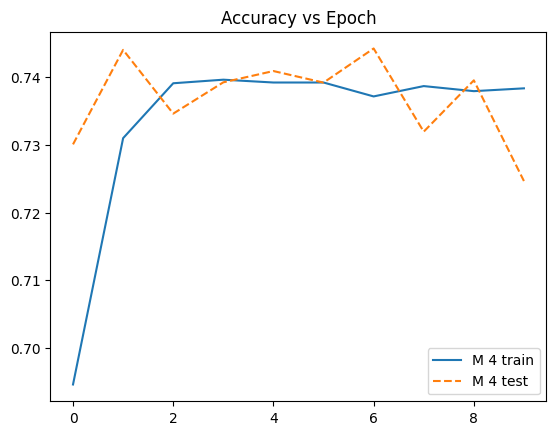

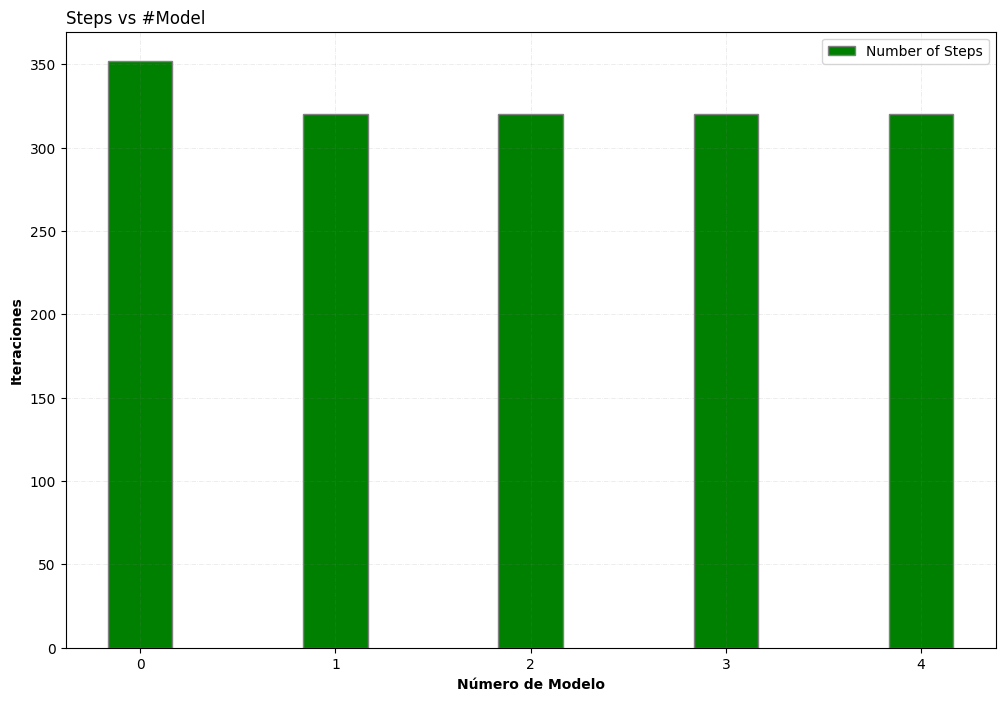

5


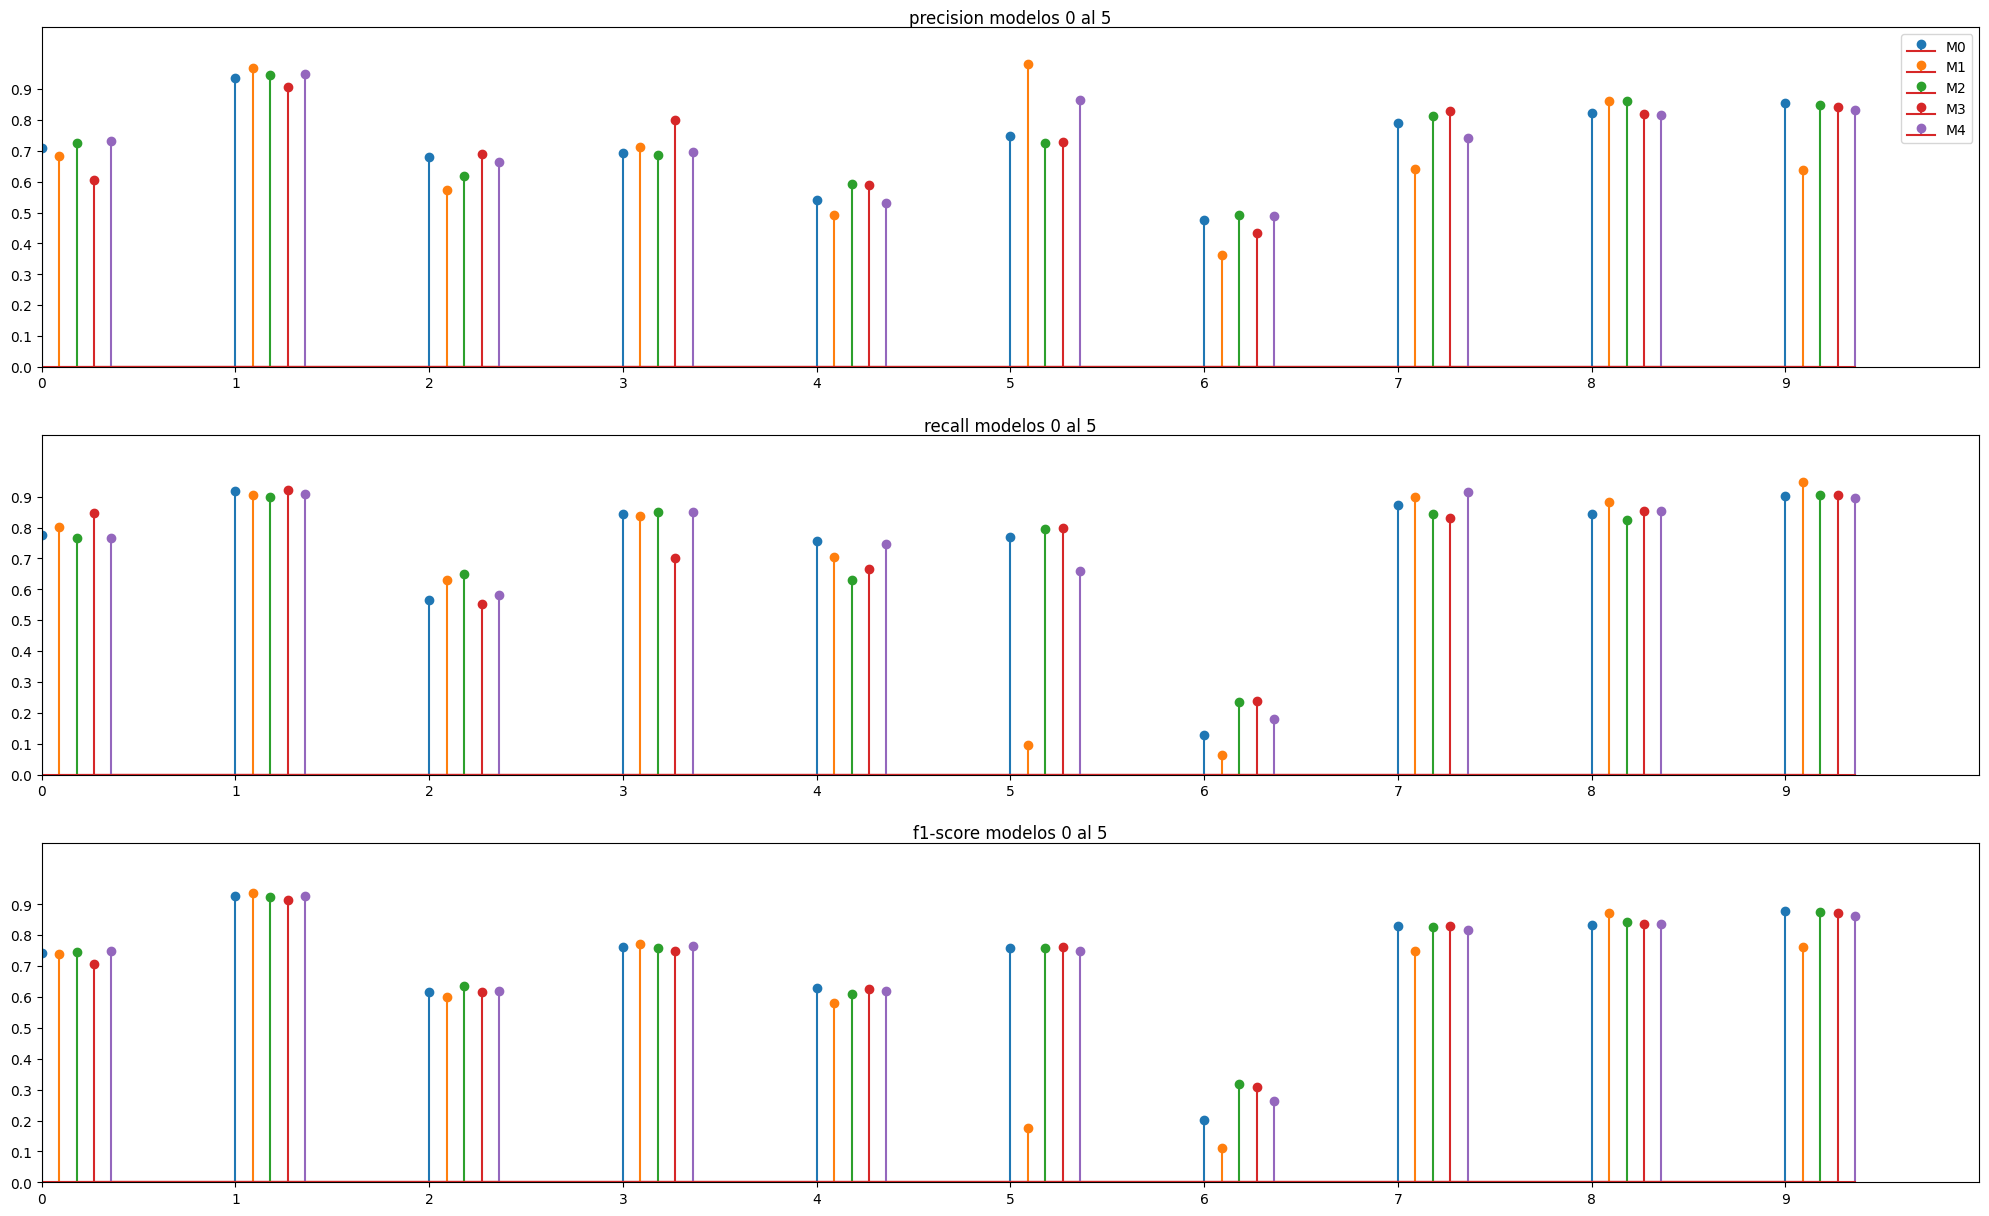

El modelo con mejor accuracy de train es el: M 0  ( Modelo con optimizacion SGD, Regularizacion kernel l1 y inicializados segun normal, con BtchSize = 32 ) ----> Acc: 0.7446666955947876
El modelo con mejor accuracy de validacion es el: M 2  ( Modelo con optimizacion Adam, Regularizacion kernel l1 y inicializados segun normal, con BtchSize = 32 ) ----> ValAcc: 0.7443333268165588
El modelo con mejor loss de train es el: M 3 ( Modelo con optimizacion RMSprop, Regularizacion kernel l1 y inicializados segun normal, con BtchSize = 32 ) ----> Loss: 1.884932279586792
El modelo con mejor loss de validacion es el: M 4 ( Modelo con optimizacion nadam, Regularizacion kernel l1 y inicializados segun normal, con BtchSize = 32 ) ----> ValLoss: 1.6478642225265503


In [69]:
optimizadores_list = ['SGD',"Adagrad",'Adam','RMSprop','nadam']
results_opt_vector = list()
for optimizadores in optimizadores_list:
        model_results_tuple = new_model_softmax(optimizador=optimizadores)
        results_opt_vector.append(model_results_tuple)
plot_compare(results_opt_vector)
plot_class_reports(results_opt_vector)
print_best_models(results_opt_vector)


Tenemos resultados cruzados, ya que dependiendo de la metrica a observar tenemos una opcion diferente. Tomaremos Adam ya que es la que tiene mejor accuracy de validacion y ademas ofrece callbacks de LR adaptativo, lo cual puede ser util para afinar el tiempo de convergencia.Para las siguientes pruebas se utilizo Adam.

##Inicializaciones de Pesos

Modelo con optimizacion Adam, Regularizacion kernel l1 y inicializados segun normal, con BtchSize = 32
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_19 (Flatten)        (None, 784)               0         
                                                                 
 dense_19 (Dense)            (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
1115/1125 [============================>.] - ETA: 0s - loss: 1.9068 - accuracy: 0.6964
Epoch 1: val_accuracy improved from -inf to 0.72929, saving model to Modelo con optimizacion Adam, Regularizacion kernel l1 y inicializados segun normal, con BtchSize = 32.h5
1125/1125 [==============================] - 4s 3ms/step - loss: 1.904

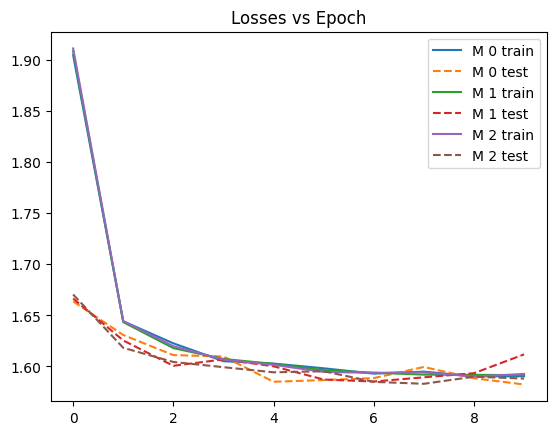

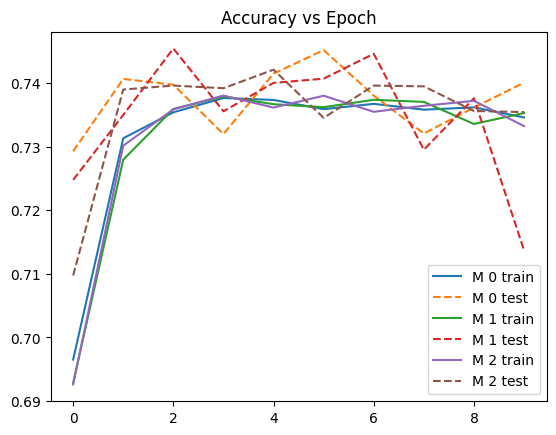

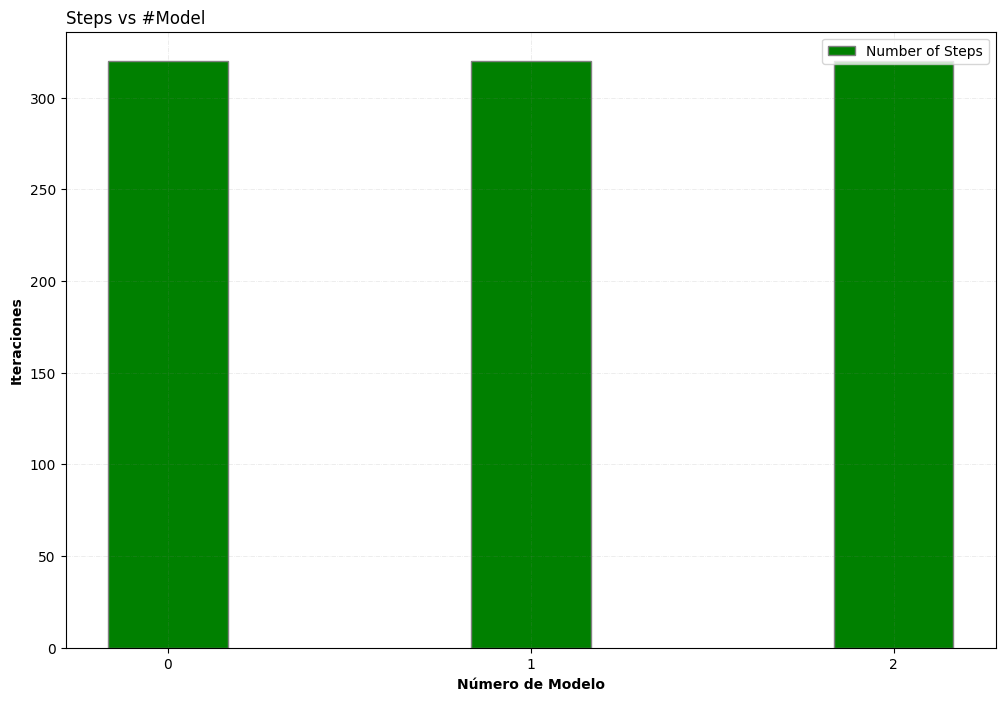

3


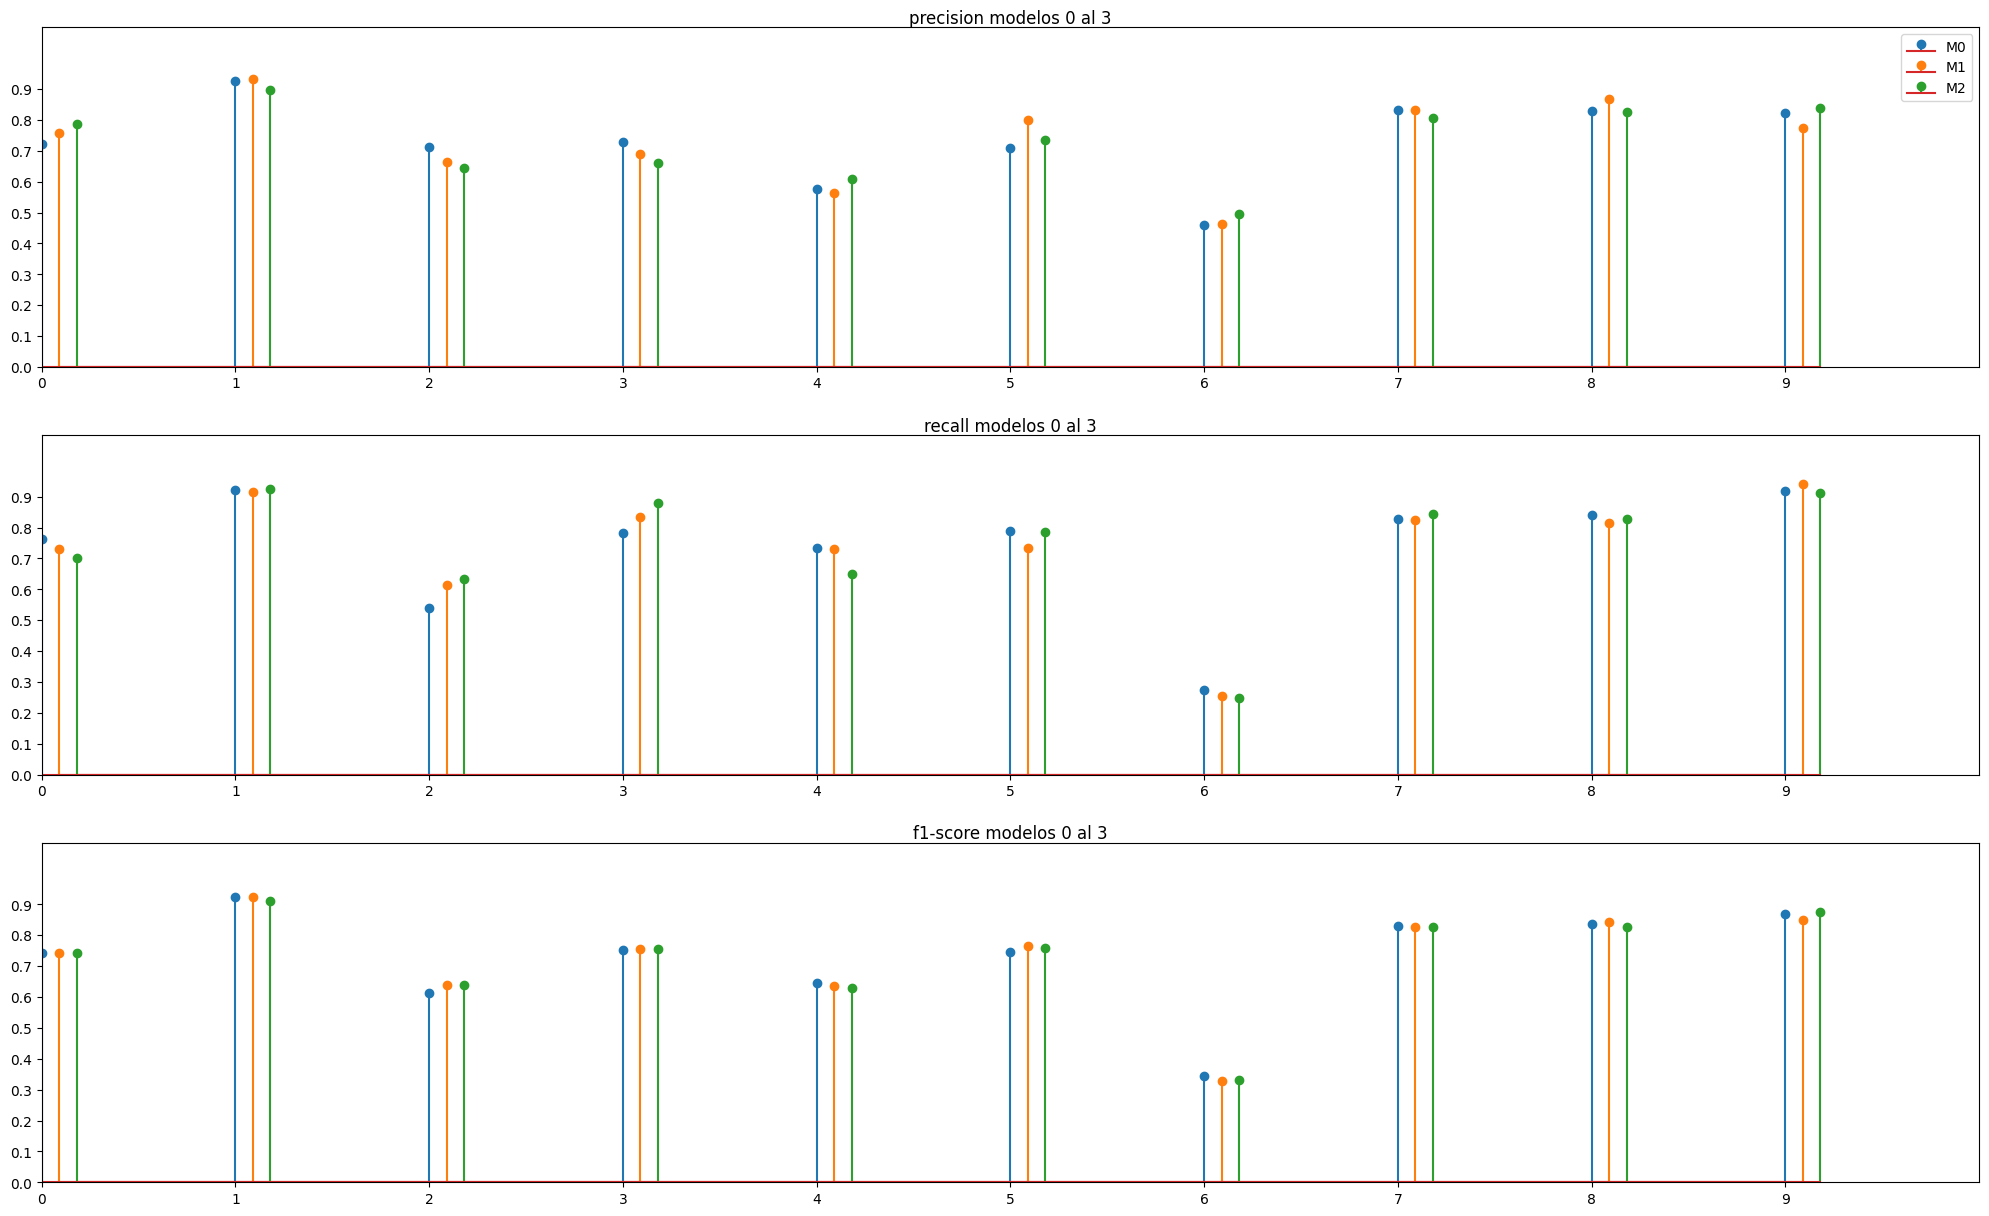

El modelo con mejor accuracy de train es el: M 2  ( Modelo con optimizacion Adam, Regularizacion kernel l1 y inicializados segun glorot_normal, con BtchSize = 32 ) ----> Acc: 0.7380555272102356
El modelo con mejor accuracy de validacion es el: M 1  ( Modelo con optimizacion Adam, Regularizacion kernel l1 y inicializados segun glorot_uniform, con BtchSize = 32 ) ----> ValAcc: 0.7454583048820496
El modelo con mejor loss de train es el: M 0 ( Modelo con optimizacion Adam, Regularizacion kernel l1 y inicializados segun normal, con BtchSize = 32 ) ----> Loss: 1.9048904180526733
El modelo con mejor loss de validacion es el: M 0 ( Modelo con optimizacion Adam, Regularizacion kernel l1 y inicializados segun normal, con BtchSize = 32 ) ----> ValLoss: 1.6637331247329712


In [70]:
kerninits_list=['normal','glorot_uniform','glorot_normal']
results_ki_vector = list()
for kerninits in kerninits_list:
  model_results_tuple = new_model_softmax(kerninit=kerninits)
  results_ki_vector.append(model_results_tuple)

plot_compare(results_ki_vector)
plot_class_reports(results_ki_vector)
print_best_models(results_ki_vector)

Tenemos resultados cruzados para este caso, donde notamos que para inicializacion de pesos RandomNormal tenemos mejores losses (train y val) pero el accuracy es mejor con Glorot Normal / Glorot Uniform.
Para las siguientes pruebas se tomó Random Normal.

##Batch Normalization

Modelo con optimizacion Adam, Regularizacion kernel l1 y inicializados segun normal, con BtchSize = 32
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_22 (Flatten)        (None, 784)               0         
                                                                 
 batch_normalization (BatchN  (None, 784)              3136      
 ormalization)                                                   
                                                                 
 dense_22 (Dense)            (None, 10)                7850      
                                                                 
Total params: 10,986
Trainable params: 9,418
Non-trainable params: 1,568
_________________________________________________________________
Epoch 1/200
1106/1125 [============================>.] - ETA: 0s - loss: 1.4405 - accuracy: 0.7659
Epoch 1: val_accuracy improved from -inf t

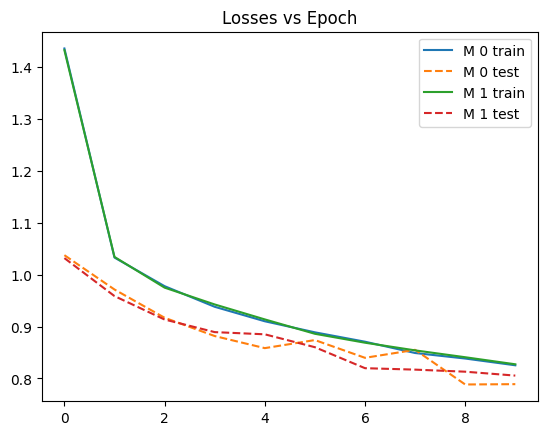

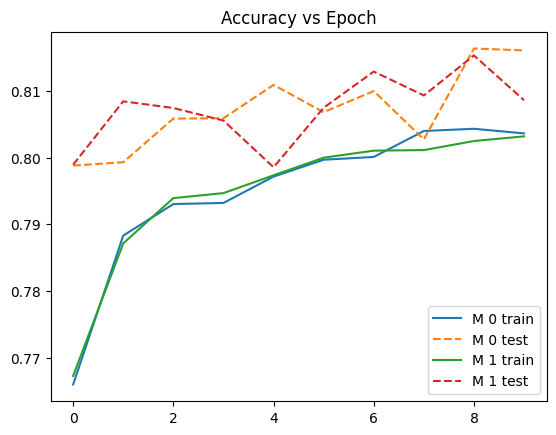

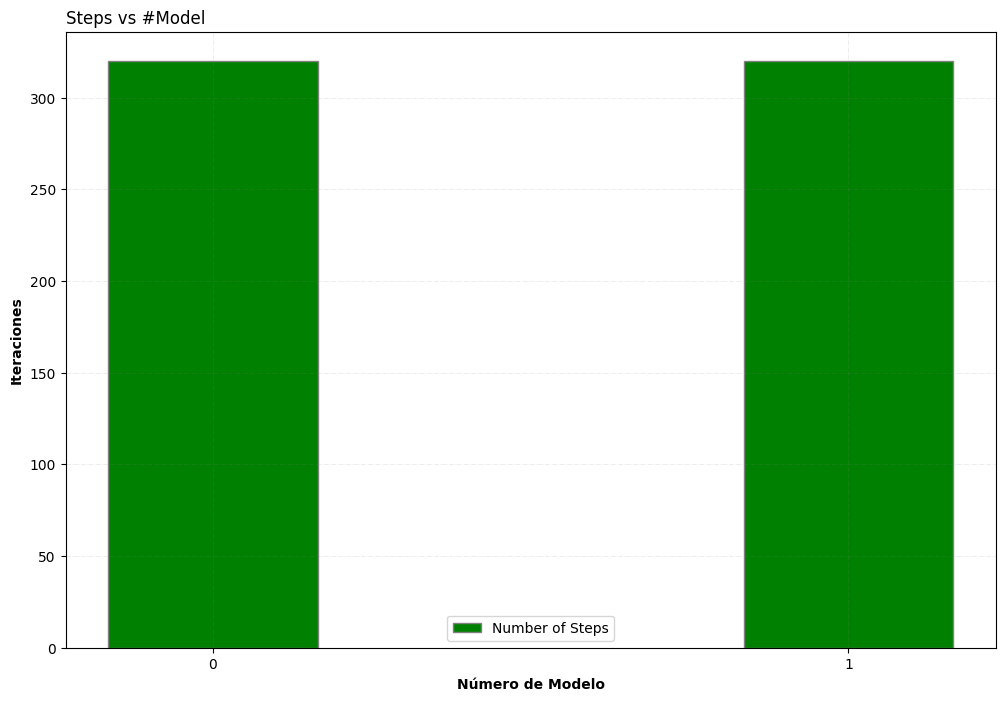

2


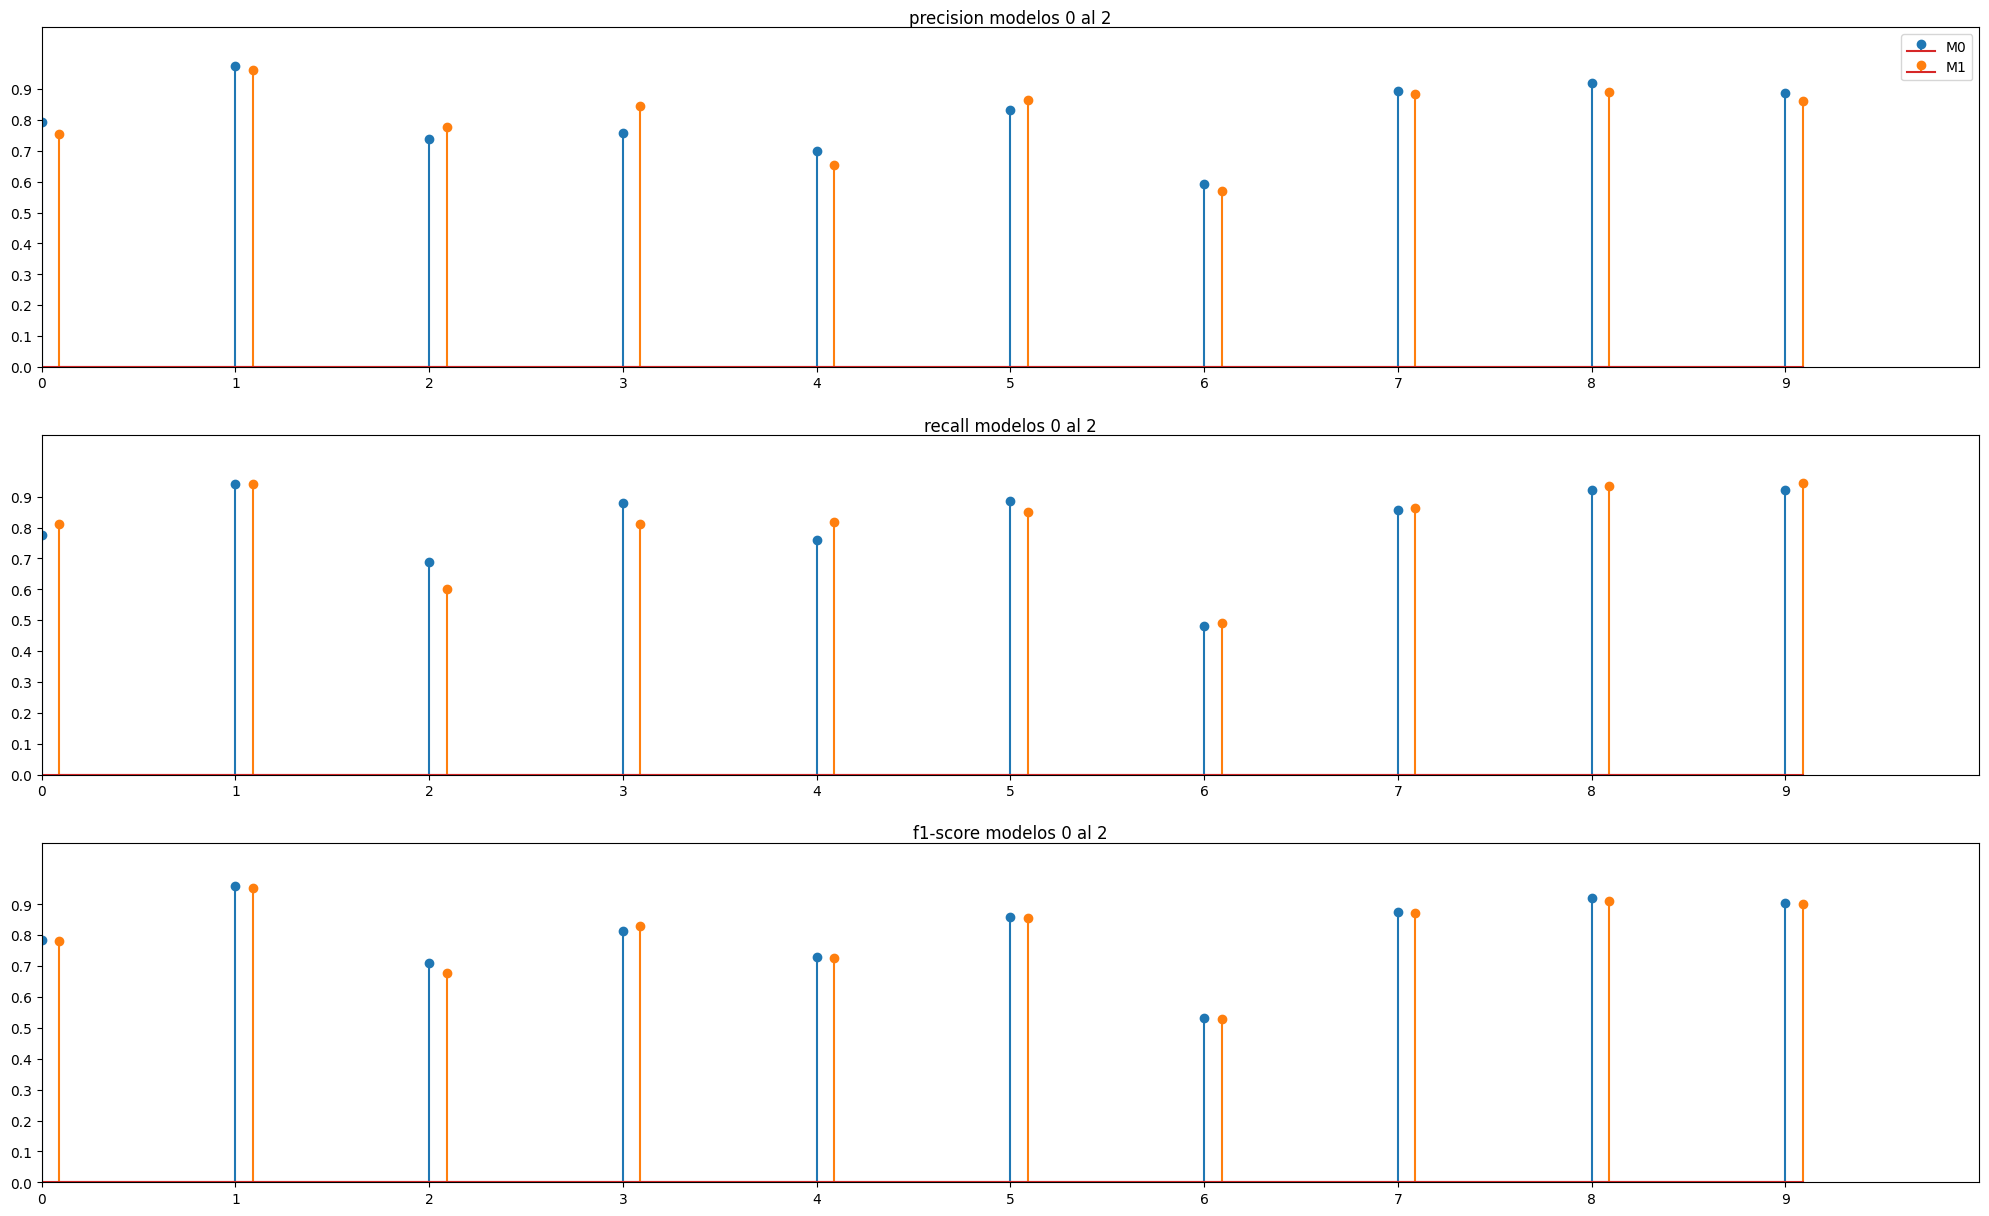

El modelo con mejor accuracy de train es el: M 0  ( Modelo con optimizacion Adam, Regularizacion kernel l1 y inicializados segun normal, con BtchSize = 32 ) ----> Acc: 0.8043055534362793
El modelo con mejor accuracy de validacion es el: M 0  ( Modelo con optimizacion Adam, Regularizacion kernel l1 y inicializados segun normal, con BtchSize = 32 ) ----> ValAcc: 0.8163333535194397
El modelo con mejor loss de train es el: M 1 ( Modelo con optimizacion Adam, Regularizacion kernel l1 y inicializados segun normal, con BtchSize = 32 ) ----> Loss: 1.4316235780715942
El modelo con mejor loss de validacion es el: M 1 ( Modelo con optimizacion Adam, Regularizacion kernel l1 y inicializados segun normal, con BtchSize = 32 ) ----> ValLoss: 1.0316014289855957


In [71]:
batchnorms = ['False', 'True']
results_bn_vector = list()
for batchnorm in batchnorms:
  model_results_tuple = new_model_softmax(batch_normalization = batchnorm)
  results_bn_vector.append(model_results_tuple)

plot_compare(results_bn_vector)
plot_class_reports(results_bn_vector)
print_best_models(results_bn_vector)

Notamos que las diferencias entre ubicar o no una capa de Batch Normalization es minima, lo cual es logico considerando que estamos entrenando un modelo de una capa con datos de entrada previamente normalizados. Para futuras pruebas se desactivó esta opcion.

##Regularizacion de Pesos


Modelo con optimizacion Adam, Sin regularizacion de pesos y inicializados segun normal,con BtchSize = 32
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_25 (Flatten)        (None, 784)               0         
                                                                 
 dense_25 (Dense)            (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
1104/1125 [============================>.] - ETA: 0s - loss: 0.6766 - accuracy: 0.7683
Epoch 1: val_accuracy improved from -inf to 0.82708, saving model to Modelo con optimizacion Adam, Sin regularizacion de pesos y inicializados segun normal,con BtchSize = 32.h5
1125/1125 [==============================] - 5s 4ms/step - loss: 0

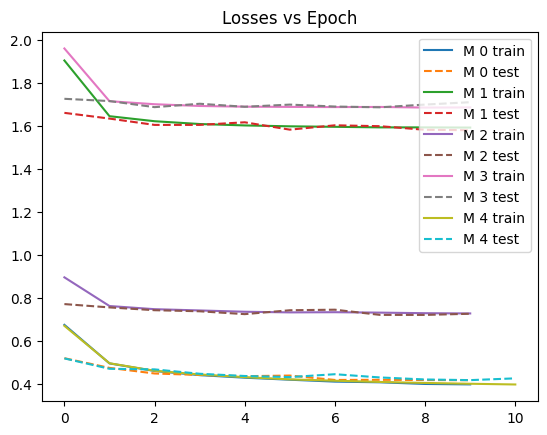

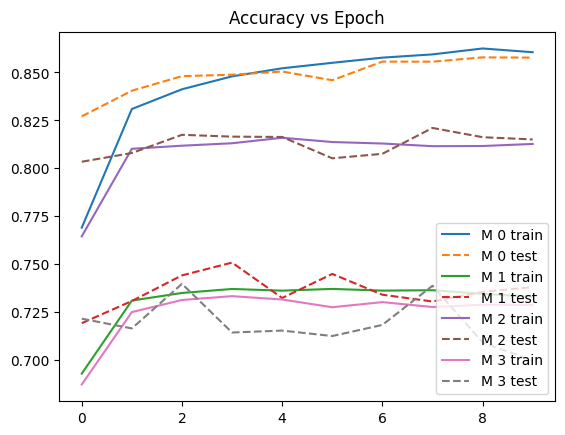

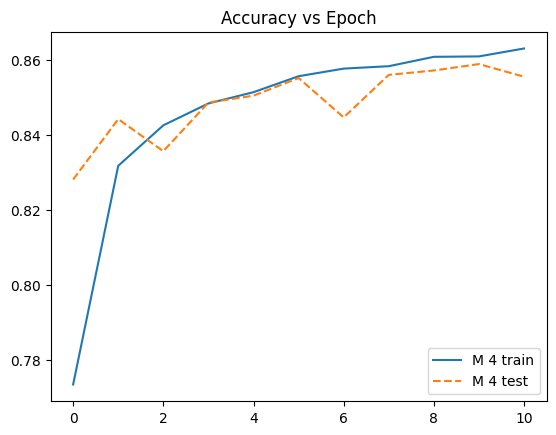

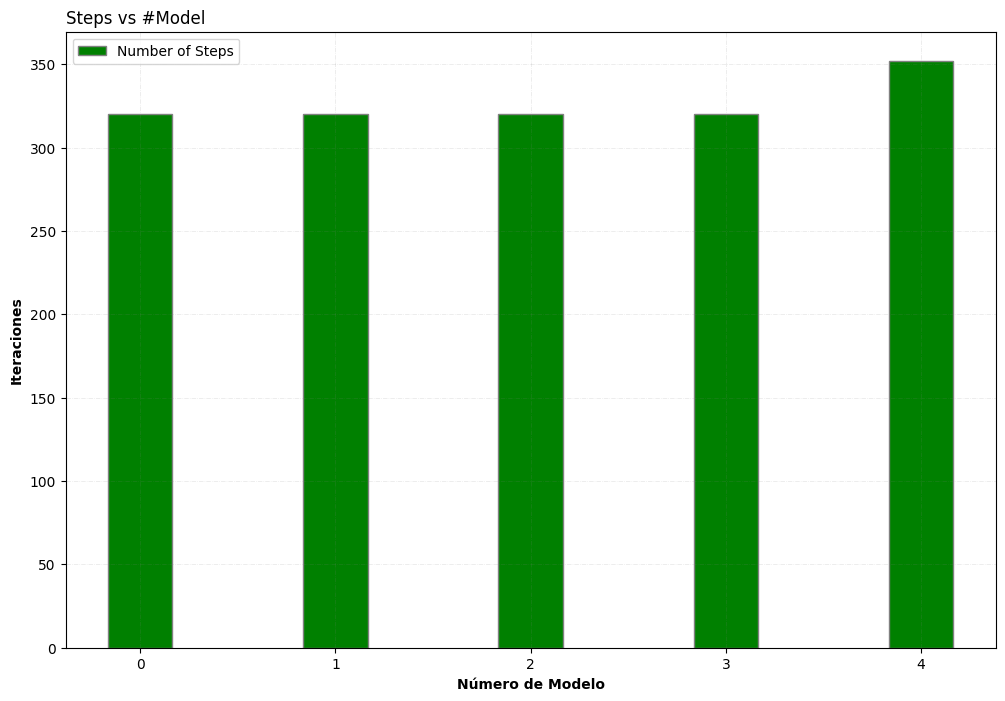

5


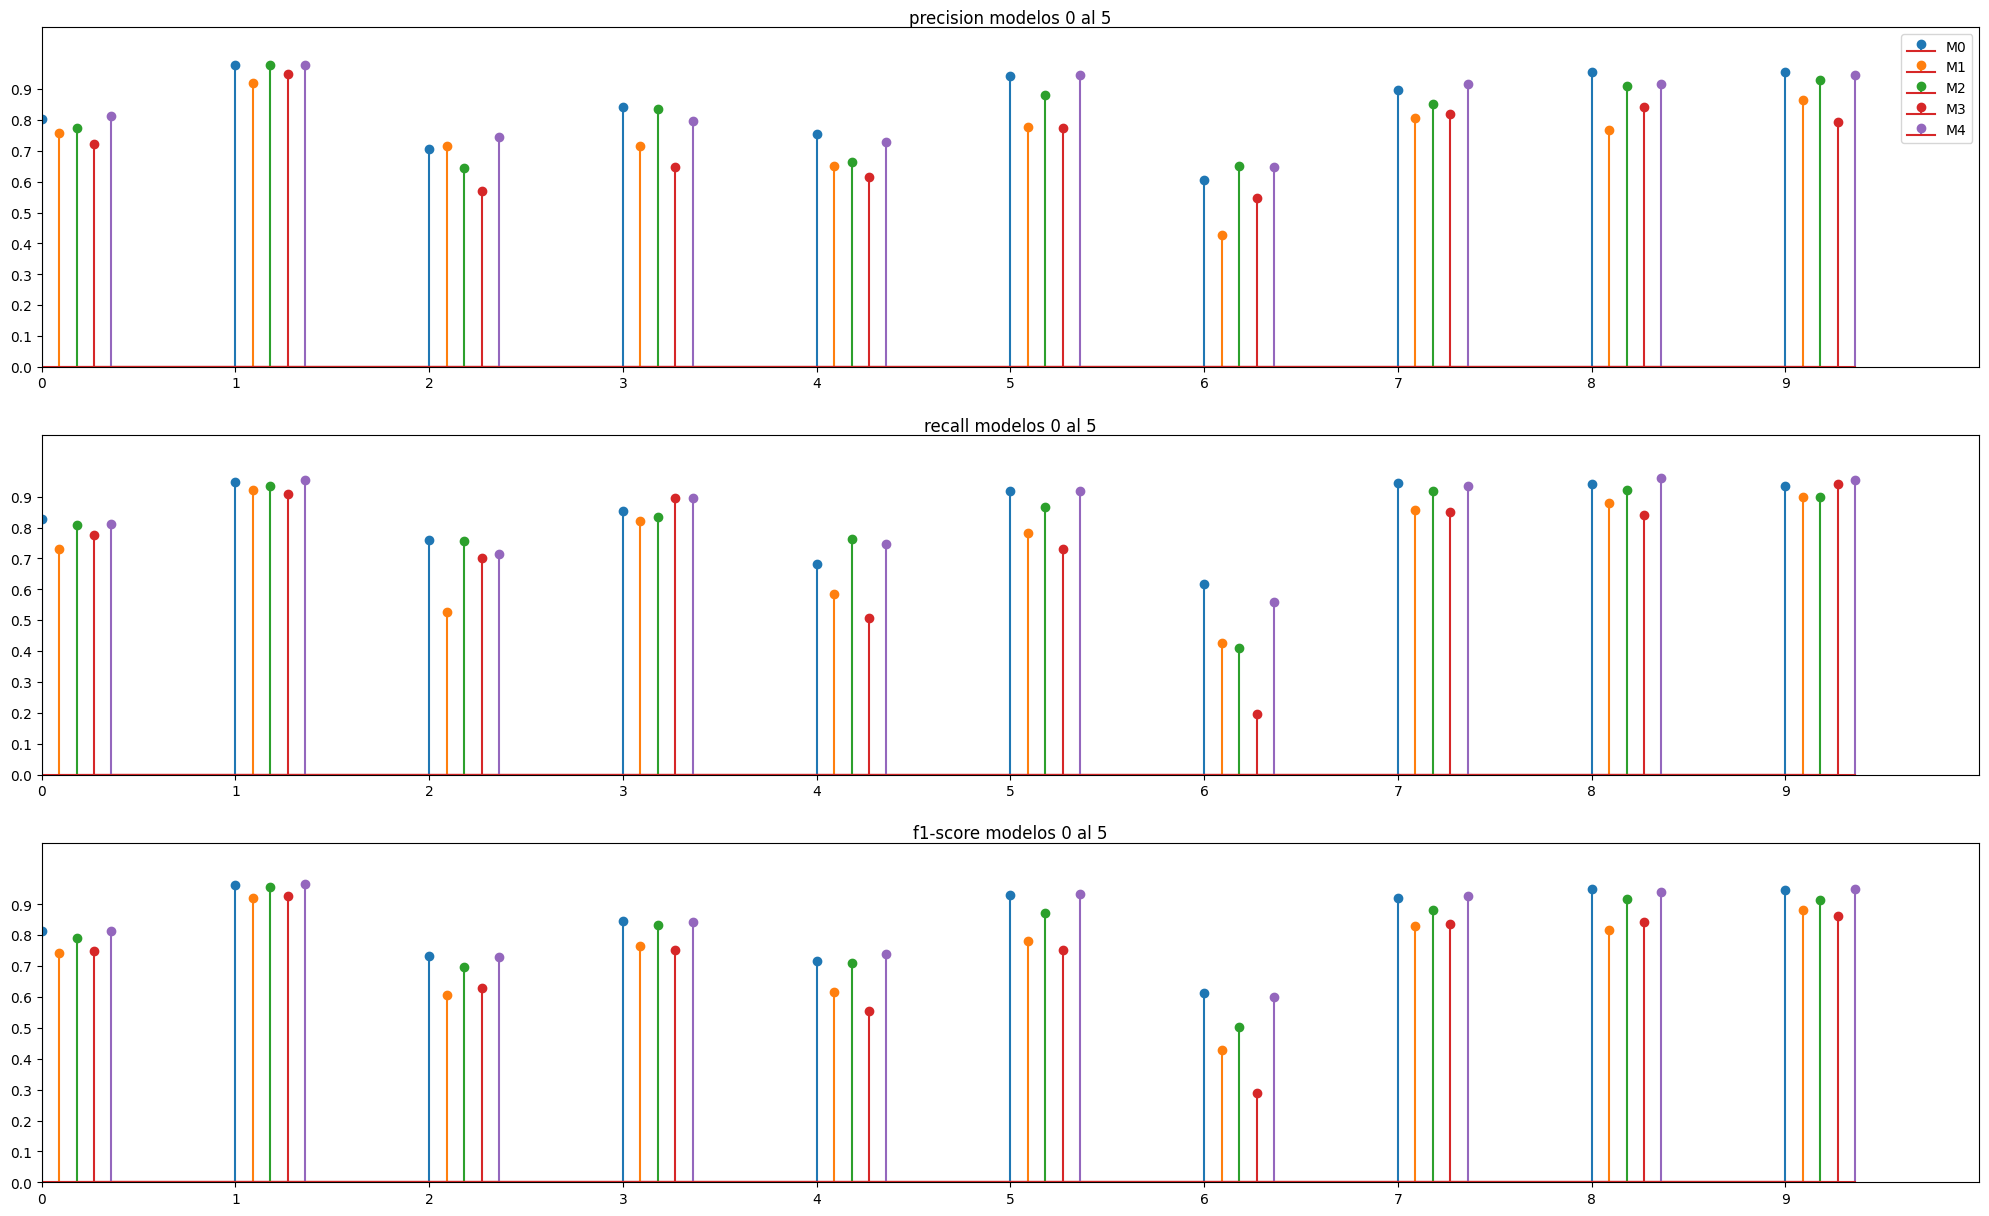

El modelo con mejor accuracy de train es el: M 4  ( Modelo con optimizacion Adam, Regularizacion kernel OrthogonalRegularizer y inicializados segun normal, con BtchSize = 32 ) ----> Acc: 0.8629444241523743
El modelo con mejor accuracy de validacion es el: M 4  ( Modelo con optimizacion Adam, Regularizacion kernel OrthogonalRegularizer y inicializados segun normal, con BtchSize = 32 ) ----> ValAcc: 0.8587916493415833
El modelo con mejor loss de train es el: M 4 ( Modelo con optimizacion Adam, Regularizacion kernel OrthogonalRegularizer y inicializados segun normal, con BtchSize = 32 ) ----> Loss: 0.6700413823127747
El modelo con mejor loss de validacion es el: M 4 ( Modelo con optimizacion Adam, Regularizacion kernel OrthogonalRegularizer y inicializados segun normal, con BtchSize = 32 ) ----> ValLoss: 0.518726646900177


In [74]:
kernregs_list= ['none','l1','l2','l1_l2','OrthogonalRegularizer']
results_kreg_vector = list()
for kernreg in kernregs_list:
  model_results_tuple = new_model_softmax(kernreg = kernreg)
  results_kreg_vector.append(model_results_tuple)

plot_compare(results_kreg_vector)
plot_class_reports(results_kreg_vector)
print_best_models(results_kreg_vector)

Las mejores metricas se observan con regularizador ortogonal. Sin embargo, si revisamos los datos no es una diferencia tan notable. Lo que si es notable es la diferencia en tiempos de corridas, donde este ultimo se demora casi el triple que los demas modelos por iteracion, por lo que para futuros modelos se tendrá en cuenta (a la hora dde necesitar mas epochs).